# Predicting Crypto prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

# X and Y
X = Goes back looking over a series of time e.g. past 7 minutes.<br>
Y = The last nth of the series of time e.g. the price of BTC on the 7th minute of the past 7 minutes.<br>

In [1]:
# Example
"""
look_back = 3
data = [1,2,4,5,7,8,9]

   X      Y
[1,2,4]->[5]
[2,4,5]->[7]
[4,5,7]->[8]
[5,7,8]->[9]
"""

'\nlook_back = 3\ndata = [1,2,4,5,7,8,9]\n\n   X      Y\n[1,2,4]->[5]\n[2,4,5]->[7]\n[4,5,7]->[8]\n[5,7,8]->[9]\n'

# Import dependencies

In [2]:
# install dependencies
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset

In [3]:
data = pd.read_csv('../datasets/Daily/gemini_BTCUSD_day.csv')

# Explore dataset

In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1644033600000,2022-02-05 04:00:00,BTCUSD,41487.51,41942.68,40971.46,41471.00,478.545315
1,1643947200000,2022-02-04 04:00:00,BTCUSD,37330.90,41996.48,37270.19,41487.51,2401.067754
2,1643860800000,2022-02-03 04:00:00,BTCUSD,36839.21,37454.49,36272.06,37330.90,1133.191332
3,1643774400000,2022-02-02 04:00:00,BTCUSD,38591.08,38801.00,36622.85,36839.21,1115.491394
4,1643688000000,2022-02-01 04:00:00,BTCUSD,38640.92,39280.00,38037.11,38591.08,1296.960431


In [5]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
2308,1444622400,2015-10-12 04:00:00,BTCUSD,248.98,248.98,245.75,245.75,71.047743
2309,1444536000,2015-10-11 04:00:00,BTCUSD,246.30,249.50,245.96,248.98,22.747091
2310,1444449600,2015-10-10 04:00:00,BTCUSD,245.51,246.30,244.60,246.30,30.870549
2311,1444363200,2015-10-09 04:00:00,BTCUSD,243.60,249.97,243.60,245.51,61.587068
2312,1444276800,2015-10-08 04:00:00,BTCUSD,0.00,245.00,0.00,243.60,34.754703


In [6]:
data.columns

Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data = data.drop(columns=['Unix Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Volume'])

In [8]:
data.shape

(2313, 2)

In [9]:
data.describe()

,Close
count,2313.000000
mean,12948.253623
std,16579.596438
min,243.600000
25%,1648.560000
50%,7227.120000
75%,11378.230000
max,68525.750000


In [10]:
data.dtypes

Date      object
Close    float64
dtype: object

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_axis(data['Date'], inplace=True)
data.set_index('Date', inplace=True)

In [12]:
data.sort_index(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2313 entries, 2015-10-08 04:00:00 to 2022-02-05 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2313 non-null   float64
dtypes: float64(1)
memory usage: 36.1 KB


In [14]:
data

,Close
Date,
2015-10-08 04:00:00,243.60
2015-10-09 04:00:00,245.51
2015-10-10 04:00:00,246.30
2015-10-11 04:00:00,248.98
2015-10-12 04:00:00,245.75
...,...
2022-02-01 04:00:00,38591.08
2022-02-02 04:00:00,36839.21
2022-02-03 04:00:00,37330.90


# Data visualisation

In [15]:
import matplotlib.pyplot as plt

In [16]:
data['Close']

Date
2015-10-08 04:00:00      243.60
2015-10-09 04:00:00      245.51
2015-10-10 04:00:00      246.30
2015-10-11 04:00:00      248.98
2015-10-12 04:00:00      245.75
                         ...   
2022-02-01 04:00:00    38591.08
2022-02-02 04:00:00    36839.21
2022-02-03 04:00:00    37330.90
2022-02-04 04:00:00    41487.51
2022-02-05 04:00:00    41471.00
Name: Close, Length: 2313, dtype: float64

In [17]:
data_close = data['Close'].values
data_close

array([  243.6 ,   245.51,   246.3 , ..., 37330.9 , 41487.51, 41471.  ])

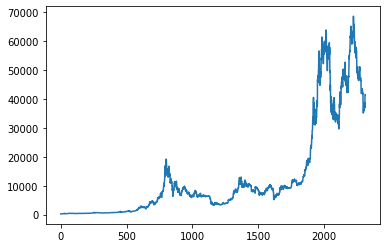

In [18]:
data_close = data_close.reshape((-1, 1))
plt.plot(data_close)
plt.show()

# Split data into train and test

In [19]:
train_size = int(len(data_close) * 0.8) # 80% of data will be for training

data_train = data_close[:train_size]
data_test = data_close[train_size:] # the rest will be for testing

print('Train data size: ', len(data_train))
print('Test data size: ', len(data_test))

Train data size:  1850
Test data size:  463


# Create time series out of data

In [20]:
look_back = 7 # look back to the past 60 minutes (one hour) of the prices

train_generator = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=64)     
test_generator = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

# Set up and build LSTM model

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2

In [22]:
# initialise model
model = Sequential()
# add layers
model.add(LSTM(50, activation='relu', input_shape=(look_back, 1), recurrent_dropout=0.2))
#model.add(Dropout(0.2, input_shape=(look_back, 1)))
model.add(Dense(1))
# compile model
model.compile(loss='mse', optimizer='adam')

In [23]:
# fit the model
num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
29/29 [==============================] - 2s 6ms/step - loss: 34044744.0000
Epoch 2/20
29/29 [==============================] - 0s 11ms/step - loss: 24383764.0000
Epoch 3/20
29/29 [==============================] - 0s 11ms/step - loss: 5456541.5000
Epoch 4/20
29/29 [==============================] - 0s 11ms/step - loss: 2820003.0000
Epoch 5/20
29/29 [==============================] - 0s 11ms/step - loss: 2231514.2500
Epoch 6/20
29/29 [==============================] - 0s 11ms/step - loss: 2388237.7500
Epoch 7/20
29/29 [==============================] - 0s 11ms/step - loss: 1836743.5000
Epoch 8/20
29/29 [==============================] - 0s 11ms/step - loss: 1178432.6250
Epoch 9/20
29/29 [==============================] - 0s 11ms/step - loss: 1046565.3750
Epoch 10/20
29/29 [==============================] - 0s 11ms/step - loss: 998757.5625
Epoch 11/20
29/29 [==============================] - 0s 10ms/step - loss: 679586.4375
Epoch 12/20
29/29 [==============================] - 

In [24]:
prediction = model.predict(test_generator)

data_train = data_train.reshape((-1))
data_test = data_test.reshape((-1))
prediction = prediction.reshape((-1))

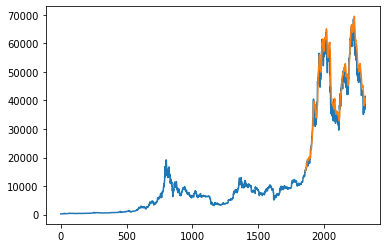

In [25]:
# Plot the predictions on a graph
prediction_plot = np.empty_like(data_close.reshape((-1)))
prediction_plot[:] = np.nan
prediction_plot[(len(data_train) + look_back):] = prediction

plt.plot(data_close)
plt.plot(prediction_plot)
plt.show()

# Make forecast

In [26]:
data_close = data_close.reshape((-1))

def predict(num_prediction, model):
    prediction_list = data_close[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

num_prediction = 100
forecast = predict(num_prediction, model)

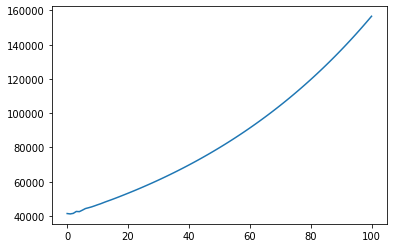

In [27]:
forecast = forecast.reshape((-1))
plt.plot(forecast)
plt.show()

In [28]:
data_forecast = np.append(data_close, forecast)

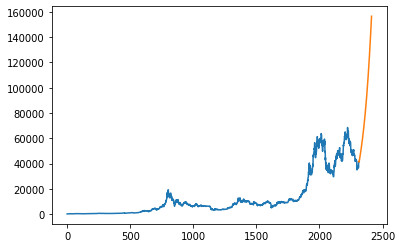

In [29]:
# Plot the forec on a graph
forecast_plot = np.empty_like(data_forecast)
forecast_plot[:] = np.nan
forecast_plot[len(data_close):] = forecast

plt.plot(data_close)
plt.plot(forecast_plot)
plt.show()